# Práctica 2. Técnicas de Optimización

### Pablo Benítez Fernández

### José Antonio Tirado Carballo

Librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import pulp
import matplotlib.pyplot as plt


## Ejercicio 1.

Dados los datos del fichero de texto titulado $isomerization.txt$ determinar los parámetros que ajustan el modelo:

$$
y = \frac{\theta_1 \theta_2 (x_2-x_3)/1.632}{1 + \theta_2 x_1 + \theta_3 x_2 + \theta_4 x_3}
$$

Se pide:

a) Linealizar el modelo y obtener una estimación inicial.

Nuestro modelo viene dado por

$$
y = \frac{1}{1.632} \cdot \frac{\theta_1 \theta_2 (x_2-x_3)}{1 + \theta_2 x_1 + \theta_3 x_2 + \theta_4 x_3}
$$.

Teniendo en cuenta que $$y(\theta_1,\theta_2,\theta_3,\theta_4) = \frac{1}{1.632} \cdot u(\theta_1,\theta_2,\theta_3,\theta_4)$$ nos bastaría con linealizar $u$, donde $u$ viene dado por:

$$
u = \frac{\theta_1 \theta_2 (x_2-x_3)}{1 + \theta_2 x_1 + \theta_3 x_2 + \theta_4 x_3}
$$



Tomando $ z = \frac{1}{u} $, tenemos que 

$$
z = \frac{1 + \theta_2 x_1 + \theta_3 x_2 + \theta_4 x_3}{\theta_1 \theta_2 (x_2-x_3)}
$$.

Por tanto podemos reescribir el modelo de la forma 

$$
z = 1.632 \cdot (\beta_0 t_0 + \beta_1 t_1 + \beta_2 t_2 + \beta_3 t_3)
$$,

donde los coeficientes y las variables son los siguientes:

$$
\begin{cases}
    \beta_0 = \frac{1.632}{{\theta_1 \theta_2}}, \quad \beta_1 = \frac{1.632\cdot\theta_2}{\theta_1 \theta_2} = \frac{1.632}{\theta_1}, \quad \beta_2 = \frac{1.632\cdot\theta_3}{\theta_1 \theta_2}, \quad \beta_3 = \frac{1.632\cdot\theta_4}{\theta_1 \theta_2}, \\
    t_0 = \frac{1}{x_2-x_3}, \quad t_1 = \frac{x_1}{x_2-x_3}, \quad t_2 = \frac{x_2}{x_2-x_3}, \quad t_3 = \frac{x_3}{x_2-x_3}
\end{cases}
$$

Una vez linealizado el modelo, podemos obtener una estimación inicial de los parámetros aplicando las técnicas conocidas para modelos de regresión lineal. 
Primero, cargamos los datos.

In [2]:
isomerizacion = pd.read_csv('isomerizacion.txt', delimiter='\t')

Calculamos los valores de $t_i$ para $i = 1,2,3,4$, y los valores de $z$ correspondientes a cada observación

In [3]:
t_0 = 1/(isomerizacion['x2']-isomerizacion['x3'])
t_1 = isomerizacion['x1']/(isomerizacion['x2']-isomerizacion['x3'])
t_2 = isomerizacion['x2']/(isomerizacion['x2']-isomerizacion['x3'])
t_3 = isomerizacion['x3']/(isomerizacion['x2']-isomerizacion['x3'])
z = 1/isomerizacion['y'] 

Agrupamos los $t_i$ en columnas para aplicar LinearRegression()

In [4]:
t = np.column_stack((t_0,t_1,t_2,t_3))

In [5]:
model  = LinearRegression(fit_intercept=False) # Nuestro modelo tal y como está expresado no tiene término independiente
model.fit(t, z)
model.coef_


array([13.30705974, -0.08201423,  0.58499586, -0.57727259])

In [6]:
# Ajuste de los coeficientes para incluir la constante
beta_ajustado = model.coef_
beta_0aj = beta_ajustado[0]
beta_1aj = beta_ajustado[1]
beta_2aj = beta_ajustado[2]
beta_3aj = beta_ajustado[3]
print(beta_ajustado)

[13.30705974 -0.08201423  0.58499586 -0.57727259]


Ahora podríamos obtener los $\theta_i$

In [7]:
theta_1 = 1.632/(beta_1aj)

theta_2 = 1.632/(theta_1*beta_0aj)

theta_3 = (beta_2aj*theta_1*theta_2)/1.632 
theta_4 = (beta_3aj*theta_1*theta_2)/1.632 

theta = np.vstack((theta_1,theta_2,theta_3,theta_4))
theta_arr = [theta_1, theta_2, theta_3, theta_4]


for valor in theta_arr:
    print(f"{valor:.8f}")

-19.89898599
-0.00616321
0.04396132
-0.04338093


Por tanto, las estimaciones iniciales de los $\theta_i$ para $i=1,2,3,4$ son:

$$
\begin{cases}
 \hat{\theta}_1 = -19.89898599 \\
 \hat{\theta}_2 = -0.00616321 \\
 \hat{\theta}_3 = 0.04396132 \\
 \hat{\theta}_4 = -0.04338093
\end{cases}
$$

b) Con la estimación inicial anterior, resolver el problema de regresión no lineal minimizando el error cuadrático.

Primero se definen el modelo no lineal (el inicial) y la función de error a minimizar para aplicar la técnica de mínimos cuadrados residual.

In [8]:
# Modelo no lineal
def modelo(theta, x1, x2, x3):
    theta1, theta2, theta3, theta4 = theta
    return (1 / 1.632) * (theta1 * theta2 * (x2 - x3)) / (1 + theta2 * x1 + theta3 * x2 + theta4 * x3)

# Función de error a minimizar
def error(theta, x1, x2, x3, y_obs):
    y_pred = modelo(theta, x1, x2, x3)
    errores = (y_pred-y_obs)**2
    return errores.sum() # Error cuadrático

A continuación se aplica la técnicas mínimos cuadrados residual mediante la función minimize(), con el método Powell, ya que el método que usa por defecto no converge.

In [9]:
# Datos de entrada
x1 = isomerizacion['x1'].values
x2 = isomerizacion['x2'].values
x3 = isomerizacion['x3'].values
y_obs = isomerizacion['y'].values

# Estimación inicial de theta
theta_inicial = [theta_1, theta_2, theta_3, theta_4]

# Método de mínimos cuadrados
resultado = minimize(error, theta_inicial, args=(x1, x2, x3, y_obs), method='Powell', options = {'disp': True})
# Método Powell por que si no el minimize no converge

# Estimación final
theta_opt = resultado.x

for valor in theta_opt:
    print(f"{valor:.8f}")


Optimization terminated successfully.
         Current function value: 35.590240
         Iterations: 46
         Function evaluations: 2506
-4203.24040928
-0.00002359
0.00091405
0.00199532


Se obtienen las estimaciones de $\theta_i$ para $i=1,2,3,4$ siguientes:

$$
\begin{cases}
 \hat{\theta}_1 = -4203.24040928 \\
 \hat{\theta}_2 = -0.00002359 \\
 \hat{\theta}_3 = 0.00091405 \\
 \hat{\theta}_4 = 0.00199532
\end{cases}
$$




c) En los dos apartados, determinar el error cuadrático medio en el modelo original.

De manera genérica, el error cuadrático de un modelo con $n$ observaciones viene determinado por:

$$
\text{ECM} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Bastaría entonces tener los valores correspondientes a las observaciones, y a las predicciones para cada modelo, y obtener el error cuadrático medio.

Correspondiente al primer apartado, tenemos los siguientes $\theta_i$ ajustados:

$$
\begin{cases}
 \hat{\theta}_1 = -19.89898599 \\
 \hat{\theta}_2 = -0.00616321 \\
 \hat{\theta}_3 = 0.04396132 \\
 \hat{\theta}_4 = -0.04338093
\end{cases}
$$

A partir de estas estimaciones, calculamos el ECM correspondiente a esas estimaciones:

In [10]:
y_pred = modelo(theta,x1,x2,x3) # en 'theta' se guardó la estimación inicial de los theta
ecm_inicial = np.mean((y_obs-y_pred)**2)
print(ecm_inicial)

27.884016312098392


$$ECM_{inicial} = 27.88402$$

Correspondiente al apartado b) tenemos los siguientes $\theta_i$ ajustados (óptimos):

$$
\begin{cases}
 \hat{\theta}_1 = -4203.24040928 \\
 \hat{\theta}_2 = -0.00002359 \\
 \hat{\theta}_3 = 0.00091405 \\
 \hat{\theta}_4 = 0.00199532
\end{cases}
$$

In [11]:
y_pred = modelo(theta_opt,x1,x2,x3) # en 'theta_opt' se guardó la estimación "óptima" obtenida con minimize, minimizando el error cuadrático
ecm_opt = np.mean((y_obs-y_pred)**2)
print(ecm_opt)

1.4829266660308151


$$ECM_{optimo} = 1.4829$$

## Ejercicio 2.

Dados los datos de la siguiente tabla:
\begin{array}{|c|c|}
\hline
X & Y \\
\hline
4.5 & 5.0 \\
5.0 & 3.8 \\
5.1 & 4.9 \\
5.3 & 3.7 \\
6.2 & 3.6 \\
7.1 & 15.0 \\
\hline
\end{array}

Determinar la recta de regresión $Y = \alpha + \beta X$ cuando el criterio a minimizar es:

a) La suma del error cuadrático, siendo $\epsilon_i = y_i - \alpha - \beta x_i$ el error de la observación $i$-ésima, con $i = 1,2,\dots,6$.

Primero de todo, cargamos los datos:

In [12]:
X = np.array([4.5, 5.0, 5.1, 5.3, 6.2, 7.1])
Y = np.array([5.0, 3.8, 4.9, 3.7, 3.6, 15.0])

A continuación, se define una función de error cuadrático a minimizar mediante minimize, obteniendo los valores óptimos de $\alpha$ y $\beta$ según este criterio.

In [13]:
# Función de error cuadrático
def error_cuadratico(params):
    alpha, beta = params
    Y_pred = alpha + beta * X
    error = np.sum((Y - Y_pred) ** 2)  # Suma de los errores cuadrados
    return error

Como no tenemos ningún valor previo de los parámetros, partimos de los valores $\alpha = 0$ y $\beta = 0$.

In [14]:
# Valores iniciales de alpha y beta
params_inicial = [0, 0]

# Minimización
resultado = minimize(error_cuadratico, params_inicial)

# Extraer los valores de alpha y beta
alpha_opt, beta_opt = resultado.x
alpha_opt, beta_opt

(-13.358454266000573, 3.4985158315588074)

Mediante el criterio de minimizar la suma del error cuadrático, se obtienen los valores:
$$
\begin{cases}
    \hat{\alpha} = -13.359 \\
    \hat{\beta} = 3.499
\end{cases}
$$

También se podría realizar empleando la función definida en el primer ejercicio de la primera práctica, para determinar la recta de regresión $y = \alpha + \beta x$ dados los datos $X,Y$:

In [15]:
def regresion_lineal(x, y):
    Y = y.T # Vector de observaciones 
    Unos = np.ones(len(x[0])) # Vector de unos para el término independiente
    X_dis = np.vstack((Unos, x)).T
    X_dis_tras = X_dis.T # Traspuesta de la matriz del diseño X
    XtX = np.dot(X_dis_tras, X_dis) # X'X
    Determinante = np.linalg.det(np.dot(X_dis_tras, X_dis))
    if Determinante == 0:
        return 'Determinante tiene que ser no nulo'
    else:
        beta = np.linalg.inv(np.dot(X_dis_tras, X_dis)).dot(X_dis_tras).dot(Y) # Parámetros estimados
        return beta    
    # La salida devuelve un array con los parámetros estimados en el siguiente orden:
    # beta_0, beta_1, ..., beta_p

Y aplicamos la función a nuestros datos:

In [16]:
regresion_lineal(X.reshape(1,-1),Y.reshape(1,-1))

array([[-13.35845697],
       [  3.49851632]])

Obteniendo los mismo valores que antes:
$$
\begin{cases}
    \hat{\alpha} = -13.359 \\
    \hat{\beta} = 3.499
\end{cases}
$$

b) La suma del valor absoluto de los errores

El problema general consiste es el siguiente:

$$
\text{Minimizar } S^a(\beta) = \sum_{i=1}^{m} (\epsilon_i^+ + \epsilon_i^-)
$$
sujeto a:
$$
y_i - \sum_{j=1}^{p} \beta_j x_{ij} - \epsilon_i^+ + \epsilon_i^- = 0 \quad \forall i = 1, 2, \dots, m
$$
$$
\epsilon_i^+, \epsilon_i^- \geq 0 \quad \forall i = 1, 2, \dots, m
$$
$$
\beta_j \text{ no restringido} \quad \forall j = 1, 2, \dots, p
$$

donde $\epsilon_i^+$ y $\epsilon_i^-$ representan las partes positiva y negativa del error $i$-ésimo.


Este modelo busca ajustar una regresión lineal minimizando la suma de los errores absolutos al descomponer cada error en una parte positiva y una negativa. Las variables de decisión son los coeficientes de la regresión, representados por $\beta_j$.

Adaptado a nuestra situación, tendríamos el problema siguiente:


$$
\text{Minimizar } S^a(\alpha, \beta) = \sum_{i=1}^{6} (\epsilon_i^+ + \epsilon_i^-)
$$
sujeto a:
$$
y_i - (\alpha + \beta x_i) - \epsilon_i^+ + \epsilon_i^-= 0 \quad \forall i = 1, 2, \dots, 6
$$
$$
\epsilon_i^+, \epsilon_i^- \geq 0 \quad \forall i = 1, 2, \dots, 6
$$
$$
\alpha, \beta \text{ no restringidos}
$$

donde $y_i$ y $x_i$ son los valores observados de $Y$ y $X$, respectivamente.

Con la librería pulp, podemos resolver el problema de la siguiente manera:

In [17]:
# Introducimos de nuevo los datos que tenemos, para recordarlos
X = np.array([4.5, 5.0, 5.1, 5.3, 6.2, 7.1])
Y = np.array([5.0, 3.8, 4.9, 3.7, 3.6, 15.0])
m = len(Y)

# Creamos el problema de optimización
problem = pulp.LpProblem("Minimizar_Suma_Absoluta_Errores", pulp.LpMinimize)

# Añadimos las variables de decisión
alpha = pulp.LpVariable("alpha", lowBound=None, upBound=None, cat="Continuous") # No restringida 
beta = pulp.LpVariable("beta", lowBound=None, upBound=None, cat="Continuous") # No restringida
# Para las variables e+ y e- usamos range(m) en "LpVariable.dicts" para crear directamente las 6 variables correspondientes a 
# e_i+ y las 6 variables correspondientes a e_i-
eps_pos = pulp.LpVariable.dicts("eps_pos", range(m), lowBound=0, upBound=None, cat="Continuous") # Restringidas a ser >= 0
eps_neg = pulp.LpVariable.dicts("eps_neg", range(m), lowBound=0, upBound=None, cat="Continuous") # Restringidas a ser >= 0

# Función objetivo: Min Σ(eps_pos + eps_neg). Con pulp podemos expresar una suma con "lpSum"
problem += pulp.lpSum([eps_pos[i] + eps_neg[i] for i in range(m)])

# Restricciones de igualdad: yi - (alpha + beta*xi) - eps_pos + eps_neg = 0 
for i in range(m):
    problem += (Y[i] - (alpha + beta * X[i]) - eps_pos[i] + eps_neg[i] == 0), f"error_balance_{i}" # Con f"error_balance_{i}" 
                                                                                    # le damos nombre a cada restricción

# Resolvemos el problema
problem.solve()

# Obtenemos los resultados
print(f"Valor del óptimo de la función objetivo: {problem.objective.value()}")
alpha_value_1 = alpha.value()
beta_value_1 = beta.value()
print(f"Alpha: {alpha_value_1}")
print(f"Beta: {beta_value_1}")
print(f"Estado: {pulp.LpStatus[problem.status]}")
    
# Podemos observar los errores positivos y negativos
print(f"\nErrores positivos y negativos:")
for i in range(m):
    print(f"eps_pos[{i}]: {eps_pos[i].value()}, eps_neg[{i}]: {eps_neg[i].value()}")

# Podemos observar también las restricciones
print(f"\nRestricciones:")
for nombre, restr in problem.constraints.items():
    print(f"{nombre}: {restr.value}")


Valor del óptimo de la función objetivo: 12.73333337
Alpha: -22.866667
Beta: 5.3333333
Estado: Optimal

Errores positivos y negativos:
eps_pos[0]: 3.8666667, eps_neg[0]: 0.0
eps_pos[1]: 0.0, eps_neg[1]: 0.0
eps_pos[2]: 0.56666667, eps_neg[2]: 0.0
eps_pos[3]: 0.0, eps_neg[3]: 1.7
eps_pos[4]: 0.0, eps_neg[4]: 6.6
eps_pos[5]: 0.0, eps_neg[5]: 0.0

Restricciones:
error_balance_0: <bound method LpAffineExpression.value of -1*alpha + -4.5*beta + 1*eps_neg_0 + -1*eps_pos_0 + 5.0 = 0>
error_balance_1: <bound method LpAffineExpression.value of -1*alpha + -5.0*beta + 1*eps_neg_1 + -1*eps_pos_1 + 3.8 = 0>
error_balance_2: <bound method LpAffineExpression.value of -1*alpha + -5.1*beta + 1*eps_neg_2 + -1*eps_pos_2 + 4.9 = 0>
error_balance_3: <bound method LpAffineExpression.value of -1*alpha + -5.3*beta + 1*eps_neg_3 + -1*eps_pos_3 + 3.7 = 0>
error_balance_4: <bound method LpAffineExpression.value of -1*alpha + -6.2*beta + 1*eps_neg_4 + -1*eps_pos_4 + 3.6 = 0>
error_balance_5: <bound method LpAffin

Obtenemos los siguientes valores óptimos:
$$
\begin{cases}
    \hat{\alpha} = -22.867 \\
    \hat{\beta} = 5.333
\end{cases}
$$

c) El máximo del valor absoluto de los errores

El problema que queremos resolver adaptado a nuestra situación es el siguiente

$$
\text{Minimizar } \epsilon_{max}
$$
sujeto a:
$$
y_i - (\alpha + \beta x_i)  - \epsilon_i^+ + \epsilon_i^- = 0 \quad \forall i = 1, 2, \dots, 6
$$
$$
\epsilon_i^+ + \epsilon_i^- \leq \epsilon_{max} \quad \forall i = 1, 2, \dots, 6
$$
$$
\epsilon_i^+, \epsilon_i^- \geq 0 \quad \forall i = 1, 2, \dots, 6
$$
$$
\alpha, \beta \text{ no restringidos}
$$

donde $\epsilon_{max}$ representa el máximo del valor absoluto de los errores.


In [18]:
# Datos
X = np.array([4.5, 5.0, 5.1, 5.3, 6.2, 7.1])
Y = np.array([5.0, 3.8, 4.9, 3.7, 3.6, 15.0])
m = len(Y)

# Creamos el problema de optimización
problem = pulp.LpProblem("Minimizar_Max_Error_Absoluto", pulp.LpMinimize)

# Añadimos las variables de decisión
alpha = pulp.LpVariable("alpha", lowBound=None, upBound=None, cat="Continuous") # No restringida
beta = pulp.LpVariable("beta", lowBound=None, upBound=None, cat="Continuous") # No restringida

# Creamos las variables de decisión e_i+ y e_i- como antes
eps_pos = pulp.LpVariable.dicts("eps_pos", range(m), lowBound=0, upBound=None, cat="Continuous") 
eps_neg = pulp.LpVariable.dicts("eps_neg", range(m), lowBound=0, upBound=None, cat="Continuous")

# Añadimos por último la variable de e_max
e_max = pulp.LpVariable("e_max", lowBound=0, cat="Continuous") 

# Función objetivo: Min e_max
problem += e_max

# Restricciones de igualdad: yi - (alpha + beta*xi) - eps_pos + eps_neg = 0
for i in range(m):
    problem += (Y[i] - (alpha + beta * X[i]) - eps_pos[i] + eps_neg[i] == 0), f"error_balance_{i}"

# Restricciones para asegurar que cada |eps_i| <= e_max
for i in range(m):
    problem += (eps_pos[i] + eps_neg[i] <= e_max), f"max_error_mayorigual_{i}"

# Resolvemos el problema
problem.solve()

# Obtenemos los resultados
alpha_value_2 = alpha.value()
beta_value_2 = beta.value()
e_max_value = e_max.value()
print(f"Alpha: {alpha_value_2}")
print(f"Beta: {beta_value_2}")
print(f"e_max (máximo error absoluto): {e_max_value}")
print(f"Valor del óptimo de la función objetivo (obviamente coincide con e_max_value): {problem.objective.value()}")
print(f"Estado: {pulp.LpStatus[problem.status]}")

# Podemos observar los errores positivos y negativos
print(f"\nErrores positivos y negativos")
for i in range(m):
    print(f"eps_pos[{i}]: {eps_pos[i].value()}, eps_neg[{i}]: {eps_neg[i].value()}")

# Podemos observar también las restricciones
print(f"\nRestricciones:")
for nombre, restr in problem.constraints.items():
    print(f"{nombre}: {restr.value}")   


Alpha: -16.276923
Beta: 3.8461538
e_max (máximo error absoluto): 3.9692308
Valor del óptimo de la función objetivo (obviamente coincide con e_max_value): 3.9692308
Estado: Optimal

Errores positivos y negativos
eps_pos[0]: 3.9692308, eps_neg[0]: 0.0
eps_pos[1]: 0.84615385, eps_neg[1]: 0.0
eps_pos[2]: 1.5615385, eps_neg[2]: 0.0
eps_pos[3]: 0.0, eps_neg[3]: 0.40769231
eps_pos[4]: 0.0, eps_neg[4]: 3.9692308
eps_pos[5]: 3.9692308, eps_neg[5]: 0.0

Restricciones:
error_balance_0: <bound method LpAffineExpression.value of -1*alpha + -4.5*beta + 1*eps_neg_0 + -1*eps_pos_0 + 5.0 = 0>
error_balance_1: <bound method LpAffineExpression.value of -1*alpha + -5.0*beta + 1*eps_neg_1 + -1*eps_pos_1 + 3.8 = 0>
error_balance_2: <bound method LpAffineExpression.value of -1*alpha + -5.1*beta + 1*eps_neg_2 + -1*eps_pos_2 + 4.9 = 0>
error_balance_3: <bound method LpAffineExpression.value of -1*alpha + -5.3*beta + 1*eps_neg_3 + -1*eps_pos_3 + 3.7 = 0>
error_balance_4: <bound method LpAffineExpression.value o

Obtenemos los siguientes valores óptimos:
$$
\begin{cases}
    \hat{\alpha} = -16.277 \\
    \hat{\beta} = 3.846
\end{cases}
$$

Como último paso, vamos a representar gráficamente las tres rectas de regresión para ilustrar las diferencias.

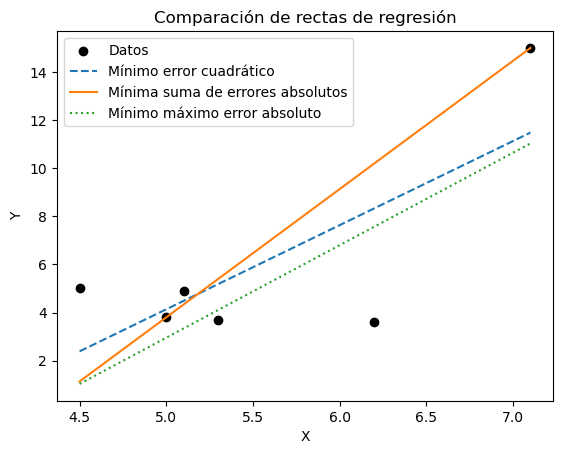

In [19]:
# Datos
plt.scatter(X, Y, color="black", label="Datos")

# Rectas de regresión
plt.plot(X, alpha_opt + beta_opt * X, label="Mínimo error cuadrático", linestyle='--')
plt.plot(X, alpha_value_1 + beta_value_1 * X, label="Mínima suma de errores absolutos", linestyle='-')
plt.plot(X, alpha_value_2 + beta_value_2 * X, label="Mínimo máximo error absoluto", linestyle=':')

# Configuraciones de la gráfica
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Comparación de rectas de regresión")
plt.show()

$\textbf{Mínimo error cuadrático:}$ Tiende a ajustarse en promedio a los datos, minimizando los errores al cuadrado, de esta forma podemos conseguir que sea menos sensible a valores atípicos, pero por otra parte puede presentar errores relativamente grandes en algunos puntos. $ \\ $
$\textbf{Mínima suma de errores absolutos:}$ Se observa claramente como ha afectado el punto en $Y=15$, que ha inclinado la recta hacia ese valor. $\\$
$\textbf{Mínimo máximo error absoluto:}$ Minimiza el valor máximo de los errores absolutos, lo que resulta en una recta que trata de mantener todos los errores en un rango similar. Esto hace que la recta se ajuste de tal manera que ningún punto tenga un error excesivamente grande, lo cual se hace evidente en el gráfico ya que la recta se encuentra en una posición intermedia.